# Деревья решений решают проблемы
__Суммарное количество баллов: 10__

Вы уже знакомы с классификацией методом KNN. В этом задании предстоит реализовать другой метод классификации - дерево решений. 

Одной из его особенностей является возможность объяснить в человекочитаемой форме, почему мы отнесли объект к определенному классу. Эта особенность позволяет использовать деревья решений для создания систем, которые могут подсказывать специалистам, на что именно стоит обратить внимание при принятии решений.

In [113]:
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split as tss
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib
from sklearn import tree

### Задание 1 (2 балла)
Во время построения дерева решений нам потребуется определить, какой из предикатов лучше всего разбивает обучающую выборку. Есть два критерия, которые позволяют это сделать: критерий Джини и энтропийный критерий. Первый для подсчета информативности разбиения использует коэффициент Джини, второй - энтропию. Реализуйте подсчет этих коэффициентов, а так же подсчет информативности разбиения. 

p.s. Считаю, что метка - 0 или 1.

#### Описание функций
`gini(x)` считает коэффициент Джини для массива меток

Пояснение: так как класса только два (и вероятности симметричны), то можно не просуммировать, а просто умножить на 2.


`entropy(x)` считает энтропию для массива меток

`gain(left_y, right_y, criterion)` считает информативность разбиения массива меток на левую `left_y` и правую `right_y` части при помощи `criterion`, который задается функцией (не строкой).

In [114]:
def gini(x):
    p_1 = sum(x)/len(x)
    p_2 = 1-p_1
    return 2 * p_1 * p_2
    
def entropy(x):
    p_1 = sum(x)/len(x)
    p_2 = 1-p_1
    return - p_1 * np.log2(p_1) - p_2 * np.log2(p_2)

def gain(left_y, right_y, criterion):
#   Пусть total = node, т.к. не знаем тотал
    len_l = len(left_y)
    len_r = len(right_y)
    return criterion(np.concatenate((left_y, right_y), axis=0)) - (len_l * criterion(np.array(left_y)) + len_r * criterion(np.array(right_y))) / (len_l + len_r)

### Задание 2 (2 балла)
Деревья решений имеют хорошую интерпретируемость, т.к. позволяют не только предсказать класс, но и объяснить, почему мы предсказали именно его. Например, мы можем его нарисовать. Чтобы сделать это, нам необходимо знать, как оно устроено внутри. Реализуйте классы, которые будут задавать структуру дерева. 

#### DecisionTreeLeaf
Поля:
1. `y` должно содержать класс, который встречается чаще всего среди элементов листа дерева

#### DecisionTreeNode
В данной домашней работе мы ограничемся порядковыми и количественными признаками, поэтому достаточно хранить измерение и значение признака, по которому разбиваем обучающую выборку.

Поля:
1. `split_dim` измерение, по которому разбиваем выборку
2. `split_value` значение, по которому разбираем выборку
3. `left` поддерево, отвечающее за случай `x[split_dim] < split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`
4. `right` поддерево, отвечающее за случай `x[split_dim] >= split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

__Интерфейс классов можно и нужно менять при необходимости__ (например, для вычисления вероятности в следующем задании)

In [115]:
class DecisionTreeLeaf:
    def __init__(self, y):
        self.y = y

class DecisionTreeNode:
    def __init__(self, split_dim, split_value, left, right):
        self.split_dim = split_dim
        self.split_value = split_value
        self.left = left
        self.right = right

### Задание 3 (6 баллов)
Теперь перейдем к самому дереву решений. Реализуйте класс `DecisionTreeClassifier`.

#### Описание методов
`fit(X, y)` строит дерево решений по обучающей выборке.

`predict_proba(X)` для каждого элемента из `X` возвращает словарь `dict`, состоящий из пар `(класс, вероятность)`. Вероятности классов в листе можно определить через количество объектов соответствующего класса в листе. 

#### Описание параметров конструктора
`criterion="gini"` - задает критерий, который будет использоваться при построении дерева. Возможные значения: `"gini"`, `"entropy"`.

`max_depth=None` - ограничение глубины дерева. Если `None` - глубина не ограничена

`min_samples_leaf=1` - минимальное количество элементов в каждом листе дерева.

#### Описание полей
`root` - корень дерева. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

In [172]:
class DecisionTreeClassifier:
    def __init__(self, criterion='gini', max_depth=None, min_samples_leaf=1):
        if criterion == 'gini':
            self.criterion = gini
        else:
            self.criterion = entropy
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.cur_depth = 0
        
    def recursive_build_tree(self, X, y, depth):
#       STEP 1
#       Если все точки одинаковые, или листов 
#       меньше, или глубже нельзя, то останавливаемся
        if len(np.unique(y)) == 1 or len(y) <= self.min_samples_leaf or depth == self.max_depth: 
            return DecisionTreeLeaf(y.to_numpy())
#       STEP 2
#       Find the threshold with the best information gain.
#       No threshold yields information gain -> mark the
#       node with the majority class (or assign class
#       probability) and stop.
        max_gain, max_split_val, max_dim = float('-inf'), float('-inf'), -1 
        for cur_dim_i in range(X.shape[1]):
            cur_dim = X[str(cur_dim_i+1)]
            for cur_split_val in np.nditer(cur_dim):
                left_ind = cur_dim < cur_split_val
                right_ind = cur_dim >= cur_split_val
                left_y = y.loc[left_ind]
                right_y = y.loc[right_ind]
                if len(left_y!=0) and len(right_y!=0):
                    cur_gain = gain(left_y, right_y, self.criterion)
                    if cur_gain > max_gain:
                        max_gain, max_split_val, max_dim_i = cur_gain, cur_split_val, cur_dim_i       
#       Step 3
#       Separate objects into children nodes by the
#       threshold rule.
        left_ind = X[str(max_dim_i + 1)] < max_split_val
        right_ind = X[str(max_dim_i + 1)] >= max_split_val
        left_y = y.loc[left_ind]
        right_y = y.loc[right_ind]
        left_X = X.loc[left_ind]
        right_X = X.loc[right_ind]
#       Step 4
#       Call 1. for every new node.
        left_tree = self.recursive_build_tree(left_X, left_y, depth + 1)
        right_tree = self.recursive_build_tree(right_X, right_y, depth + 1)
        return DecisionTreeNode(max_dim_i, max_split_val, left_tree, right_tree)
        
    
    def fit(self, X, y):
        self.root = self.recursive_build_tree(X, y, 0)
        
    def recursive_predict(self, node, x):
        if isinstance(node, DecisionTreeLeaf):
            p_1 = sum(node.y)/len(node.y)
            return {1:p_1, 0: 1-p_1}
        else:
            return self.recursive_predict(node.left if x[node.split_dim] < node.split_value else node.right, x)
    
    def predict_proba(self, X):
        answer = []
        for x in X.values:
            answer.append(self.recursive_predict(self.root, np.array(x)))
        return answer
    
    def predict(self, X):
        proba = self.predict_proba(X)
        return [max(p.keys(), key=lambda k: p[k]) for p in proba]

Построенное дерево можно нарисовать. Метод `draw_tree` рисует дерево и сохраняет его в указанный файл.

In [118]:
def tree_depth(tree_root):
    if isinstance(tree_root, DecisionTreeNode):
        return max(tree_depth(tree_root.left), tree_depth(tree_root.right)) + 1
    else:
        return 1

def draw_tree_rec(tree_root, x_left, x_right, y):
    x_center = (x_right - x_left) / 2 + x_left
    if isinstance(tree_root, DecisionTreeNode):
        x_center = (x_right - x_left) / 2 + x_left
        x = draw_tree_rec(tree_root.left, x_left, x_center, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        x = draw_tree_rec(tree_root.right, x_center, x_right, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        plt.text(x_center, y, "x[%i] < %f" % (tree_root.split_dim, tree_root.split_value),
                horizontalalignment='center')
    else:
        plt.text(x_center, y, str(tree_root.y),
                horizontalalignment='center')
    return x_center

def draw_tree(tree, save_path=None):
    td = tree_depth(tree.root)
    plt.figure(figsize=(0.33 * 2 ** td, 2 * td))
    plt.xlim(-1, 1)
    plt.ylim(0.95, td + 0.05)
    plt.axis('off')
    draw_tree_rec(tree.root, -1, 1, td)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

Для двумерного набора данных дерево можно отобразить на плоскости с данными. Кроме того, как и для любого классификатора, для него можно построить roc-кривую

In [119]:
def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

def rectangle_bounds(bounds):
    return ((bounds[0][0], bounds[0][0], bounds[0][1], bounds[0][1]), 
            (bounds[1][0], bounds[1][1], bounds[1][1], bounds[1][0]))

def plot_2d_tree(tree_root, bounds, colors):
    if isinstance(tree_root, DecisionTreeNode):
        if tree_root.split_dim:
            plot_2d_tree(tree_root.left, [bounds[0], [bounds[1][0], tree_root.split_value]], colors)
            plot_2d_tree(tree_root.right, [bounds[0], [tree_root.split_value, bounds[1][1]]], colors)
            plt.plot(bounds[0], (tree_root.split_value, tree_root.split_value), c=(0, 0, 0))
        else:
            plot_2d_tree(tree_root.left, [[bounds[0][0], tree_root.split_value], bounds[1]], colors)
            plot_2d_tree(tree_root.right, [[tree_root.split_value, bounds[0][1]], bounds[1]], colors)
            plt.plot((tree_root.split_value, tree_root.split_value), bounds[1], c=(0, 0, 0))
    else:
        x, y = rectangle_bounds(bounds)
        plt.fill(x, y, c=colors[tree_root.y] + [0.2])

def plot_2d(tree, X, y):
    plt.figure(figsize=(9, 9))
    colors = dict((c, list(np.random.random(3))) for c in np.unique(y))
    bounds = list(zip(np.min(X, axis=0), np.max(X, axis=0)))
    plt.xlim(*bounds[0])
    plt.ylim(*bounds[1])
    plot_2d_tree(tree.root, list(zip(np.min(X, axis=0), np.max(X, axis=0))), colors)
    for c in np.unique(y):
        plt.scatter(X[y==c, 0], X[y==c, 1], c=[colors[c]], label=c)
    plt.legend()
    plt.tight_layout()
    plt.show()

Протестируйте решение на данных cancer и spam.

In [120]:
def read_cancer_dataset(path_to_csv):
    # Возвращает пару из X и y. X - массив векторов. y - соответствующие векторам метки
    data = pd.read_csv(path_to_csv)
    data['label'] = (data['label'] == 'M').astype(int)
    X = data.drop("label", axis=1)
    y = data.label
    return X, y

def read_spam_dataset(path_to_csv):
    # Возвращает пару из X и y. X - массив векторов. y - соответствующие векторам метки
    data = pd.read_csv(path_to_csv)
    X = data.drop("label", axis=1)
    y = data.label
    return X, y

def train_test_split(X, y, ratio):
    # Возвращает X_train, y_train, X_test, y_test
    # X_train и X_test - массив векторов - две части массива X, разделенного в состветсви с коэффициентом ratio
    # y_train и y_test - соответствующие X_train и X_test метки классов
    X_train, X_test, y_train, y_test = tss(X, y, train_size = ratio)
    return X_train, y_train, X_test, y_test

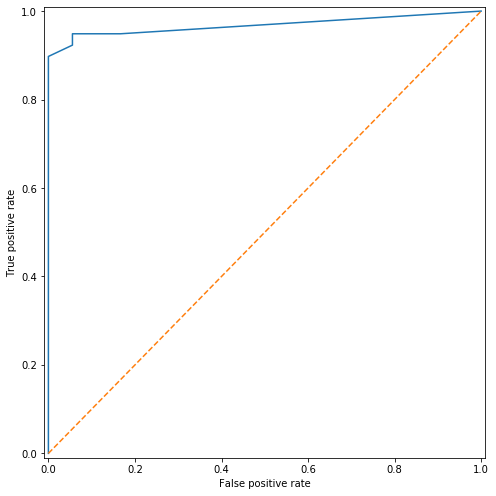

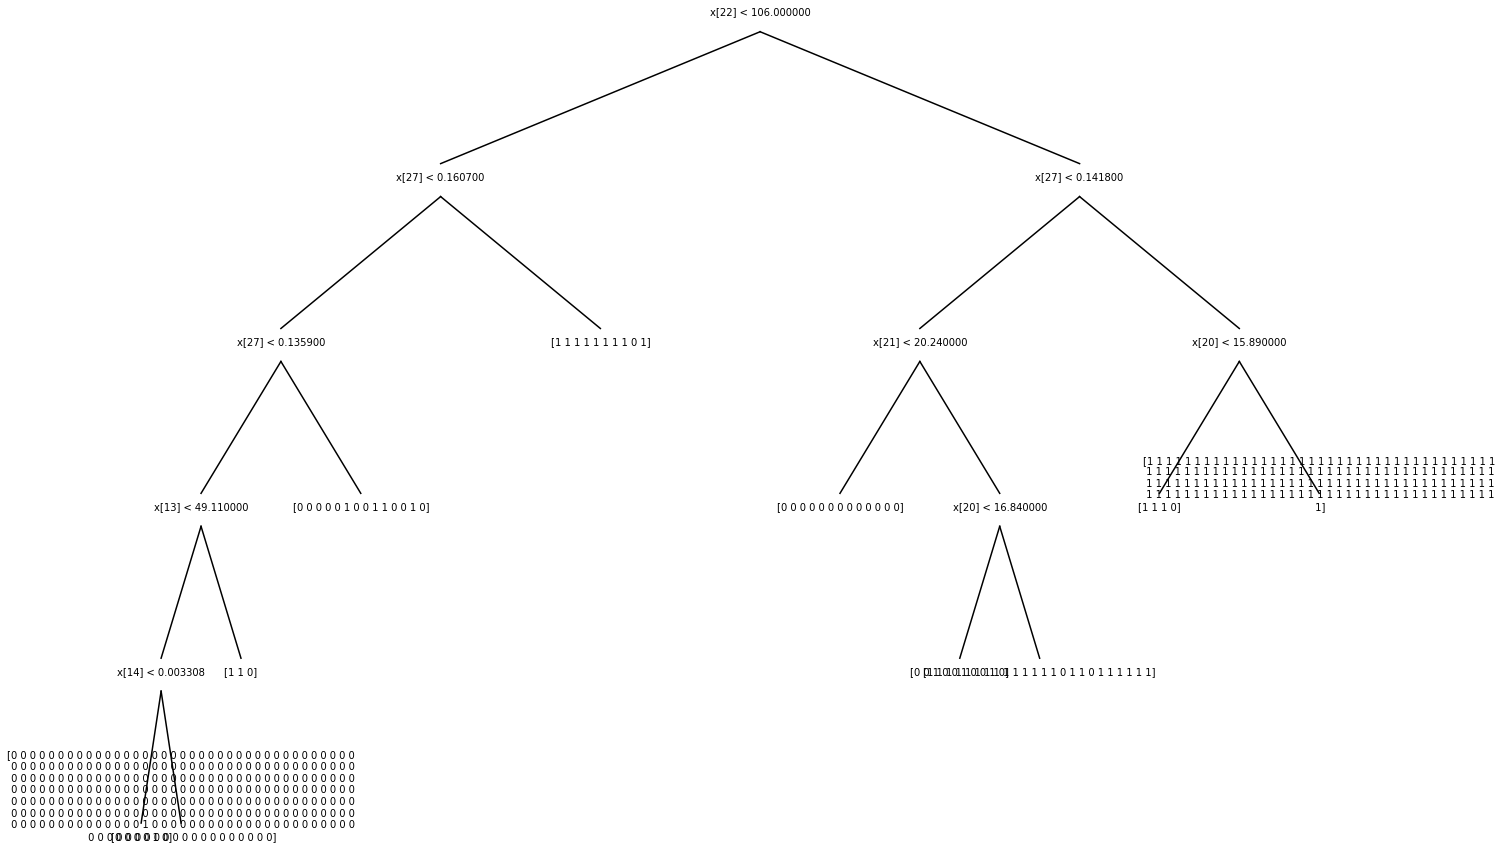

In [177]:
X, y = read_cancer_dataset("data/cancer.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X_train, y_train)
plot_roc_curve(y_test, tree.predict_proba(X_test))
draw_tree(tree)

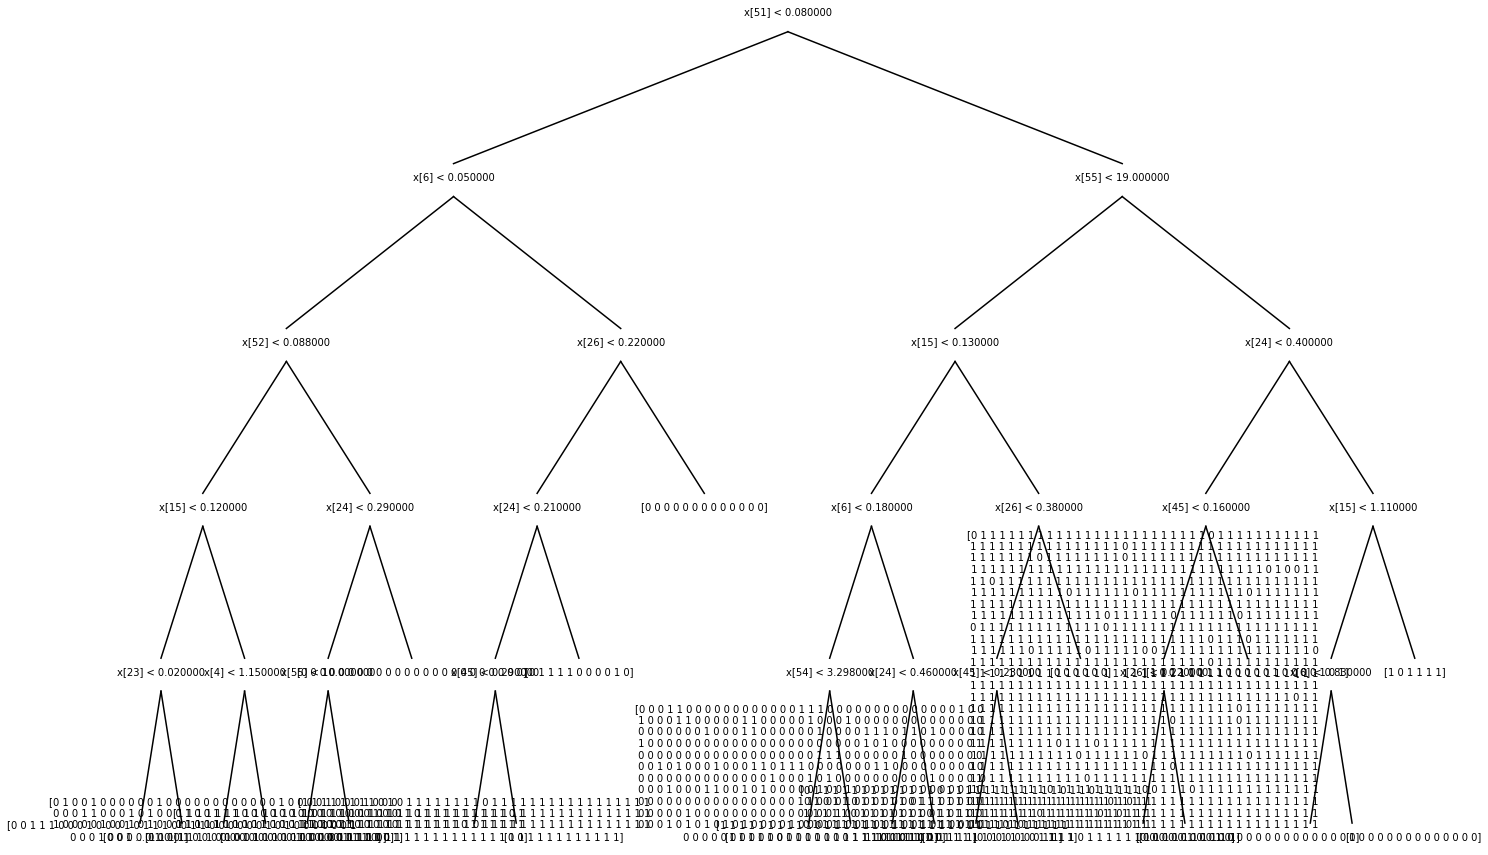

In [196]:
X, y = read_spam_dataset("data/spam.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X_train, y_train)
draw_tree(tree)

ойй, случайно удалил оттуда стрчоку для запуска теста. Вот он:

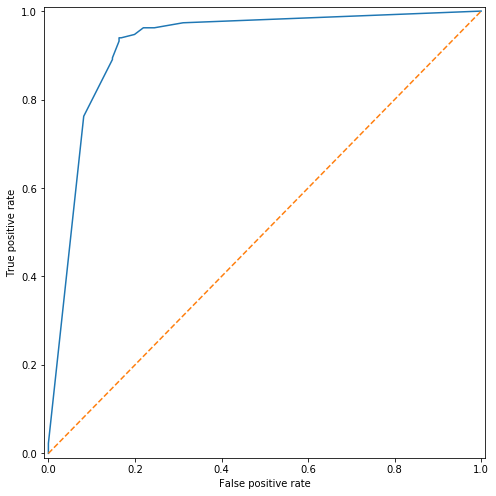

In [197]:
plot_roc_curve(y_test, tree.predict_proba(X_test))